<a href="https://colab.research.google.com/github/amilkh/cs230-fer/blob/transfer-learning/fer2013_Testing_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x
!pip install keras-vggface
!pip install scikit-image
!pip install pydot

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io

%matplotlib inline

import keras
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras_vggface.vggface import VGGFace
from keras.utils import plot_model
from sklearn.metrics import *
from keras.engine import Model
from keras.layers import Input, Flatten, Dense, Activation, Conv2D, MaxPool2D, BatchNormalization, Dropout, MaxPooling2D
import skimage
from skimage.transform import rescale, resize

import pydot

Using TensorFlow backend.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
print(tf.__version__)
print(keras.__version__)

1.15.0
2.2.5


In [0]:
Resize_pixelsize = 197

In [0]:
def get_data(dataset, pixelsize=Resize_pixelsize):
    file_stream = file_io.FileIO(dataset, mode='r')
    data = pd.read_csv(file_stream)
    data[' pixels'] = data[' pixels'].apply(lambda x: [int(pixel) for pixel in x.split()])
    X, Y = data[' pixels'].tolist(), data['emotion'].values
    X = np.array(X, dtype='float32').reshape(-1,48,48,1)
    X = X / 255.0
    X_res = np.zeros((X.shape[0], pixelsize, pixelsize, 3))
    for ind in range(X.shape[0]): 
        sample = X[ind]
        sample = sample.reshape(48, 48)
        image_resized = resize(sample, (pixelsize, pixelsize), anti_aliasing=True)
        X_res[ind, :, :, :] = image_resized.reshape(pixelsize,pixelsize,1)

    Y_res = np.zeros((Y.size, Y.max()+1))
    Y_res[np.arange(Y.size), Y] = 1  
    
    return  X_res, Y_res

In [0]:
dev_dataset_dir = '/content/drive/My Drive/cs230 project/collab/fer2013/dev.csv'
test_dataset_dir = '/content/drive/My Drive/cs230 project/collab/fer2013/test.csv'

aug = ImageDataGenerator(
    rotation_range  = 10,
    shear_range     = 10, # 10 degrees
    zoom_range      = 0.1,
    fill_mode       = 'reflect',
    horizontal_flip = True
)

X_dev, Y_dev      = get_data(dev_dataset_dir)
X_test, Y_test    = get_data(test_dataset_dir)

In [0]:
model = load_model('/content/drive/My Drive/cs230 project/models/tl/tl-SGD_LR_0.01000-EPOCHS_100-BS_128-DROPOUT_0.5test_acc_0.991.h5')
model = load_model('/content/drive/My Drive/cs230 project/models/tl-SGD_LR_0.01000-EPOCHS_10-BS_128-DROPOUT_0.5-FROZEN_101.h5')

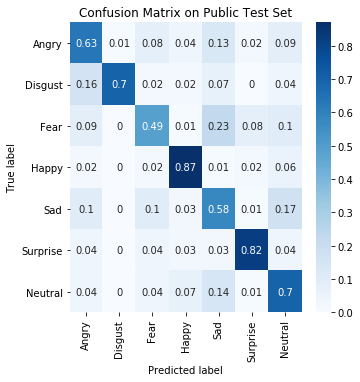

In [9]:
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

y_pred = model.predict(X_dev).argmax(axis=1)
y_true = Y_dev.argmax(axis=1)

cmat_df_test=pd.DataFrame(
  confusion_matrix(y_true, y_pred, normalize='true').round(2),
  index=emotions.values(), 
  columns=emotions.values()
  )

plt.figure(figsize=(5,5))
heatmap(cmat_df_test,annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion Matrix on Public Test Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [16]:
model.evaluate(X_dev, Y_dev)

3589/3589 [==============================] - 9s 3ms/step


[0.9060306534955813, 0.6845918083031485]

In [17]:
model.evaluate(X_test, Y_test)

3589/3589 [==============================] - 8s 2ms/step


[0.862466614420416, 0.6893285037781011]

In [0]:
from sklearn.metrics import accuracy_score
# configure image data augmentation
datagen = ImageDataGenerator(horizontal_flip=True)

# make a prediction using test-time augmentation
def tta_prediction(datagen, model, image, n_examples):
	# convert image into dataset
	samples = np.expand_dims(image, 0)
	# prepare iterator
	it = datagen.flow(samples, batch_size=n_examples)
	# make predictions for each augmented image
	yhats = model.predict_generator(it, steps=n_examples, verbose=0)
	# sum across predictions
	summed = np.sum(yhats, axis=0)
	# argmax across classes
	return np.argmax(summed)
 
 # evaluate a model on a dataset using test-time augmentation
def tta_evaluate_model(model, testX, testY):
	# configure image data augmentation
	datagen = ImageDataGenerator(horizontal_flip=True)
	# define the number of augmented images to generate per test set image
	n_examples_per_image = 7
	yhats = list()
	for i in range(len(testX)):
		# make augmented prediction
		yhat = tta_prediction(datagen, model, testX[i], n_examples_per_image)
		# store for evaluation
		yhats.append(yhat)
	# calculate accuracy
	testY_labels = np.argmax(testY, axis=1)
	acc = accuracy_score(testY_labels, yhats)
	return acc

In [12]:
print('\n# Evaluate on test data')
TTA_results_test = tta_evaluate_model(model, X_test, Y_test)
print('test loss, test acc:', results_test)
print('TTA test acc:', TTA_results_test)


# Evaluate on test data


KeyboardInterrupt: ignored